<h1 style="text-align:center;">Convolutional neural network to predict Market Yield of US Treasury Securities at 10-Year Maturity</h1>

The aim of this project is to use a CNN to predict the Market Yield of US Treasury Securities at 10 years, as a function of several variables: the credit spread between Treasuries and corporate bonds rated AAA by Moody's, the level of the stock market, expected 10-year inflation, Fed Funds rates and inflation.

<h3>Preparing the data</h3>

In [1]:
#We import the required librairies
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('dataset.csv', sep=';')

In [3]:
df['DATE'] = df['DATE'].astype('datetime64[ns]')
df.set_index('DATE', inplace = True)

In [4]:
df.head()

,DGS10,spread,share_prices,EXPINF10YR,DFF,cpi
DATE,,,,,,
1983-01-03,10.3,1.45,8.253918,4.726783,9.19,0.198294
1983-01-04,10.3,1.42,8.258667,4.731408,9.47,0.194982
1983-01-05,10.3,1.44,8.263417,4.736034,8.46,0.191670
1983-01-06,10.3,1.35,8.268167,4.740660,8.48,0.188359
1983-01-07,10.3,1.38,8.272917,4.745286,8.27,0.185047


Text(0, 0.5, 'Market Yield')

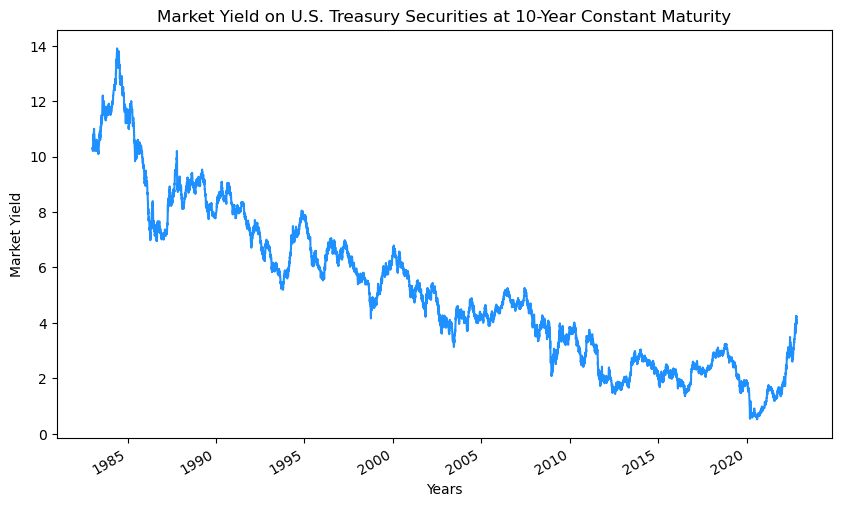

In [5]:
df[['DGS10']].plot(title='Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity',figsize=(10, 6), legend=False, color='dodgerblue')
plt.xlabel('Years')
plt.ylabel('Market Yield')

In [6]:
df = df.reset_index()

In [7]:
x_data = df.drop(df.columns[[0, 1]], axis=1, inplace=False)
y_data = df[['DGS10']]

In [8]:
x = np.array(x_data)
y = np.array(y_data)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #Splitting between train and test data

scaler = StandardScaler() #Rescale data for better performance
X_train_normalized = scaler.fit_transform(x_train)
X_train = X_train_normalized.reshape((X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
X_test_normalized = scaler.fit_transform(x_test)
X_test = X_test_normalized.reshape((X_test_normalized.shape[0], 1, X_test_normalized.shape[1]))

Y_test_normalized = scaler.fit_transform(y_test)
Y_test = Y_test_normalized.reshape((Y_test_normalized.shape[0], 1, Y_test_normalized.shape[1]))
Y_train_normalized = scaler.fit_transform(y_train)
Y_train = Y_train_normalized.reshape((Y_train_normalized.shape[0], 1, Y_train_normalized.shape[1]))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (7967, 1, 5)
X_test shape: (1992, 1, 5)
Y_train shape: (7967, 1, 1)
Y_test shape: (1992, 1, 1)


<h3>Building the model</h3>

In [10]:
# CNN model building
model = models.Sequential()

# First convolution layer
model.add(layers.Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]), padding='same'))
model.add(layers.MaxPooling1D(pool_size=1))

#Dropout to avoid overfitting
model.add(layers.Dropout(0.2))

# Second convolution layer
model.add(layers.Conv1D(filters=32, kernel_size=6, activation='relu', padding='same'))
model.add(layers.MaxPooling1D(pool_size=1))

# Flatten the data
model.add(layers.Flatten())

# Dense layer
model.add(layers.Dense(100, activation='relu'))

# Output
model.add(layers.Dense(1))  # Prédiction des rendements à 1, 2, 5, 10, et 30 ans

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae']) #We use a lowered learning rate to avoid overfitting

In [11]:
tf.saved_model.save(model, 'model')
model.summary()

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             1984      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 32)             12320     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 32)                0

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,         
    restore_best_weights=True
)

In [13]:
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
498/498 [==============================] - 3s 3ms/step - loss: 4.6468 - mae: 1.3116 - val_loss: 0.2564 - val_mae: 0.4052
Epoch 2/50
498/498 [==============================] - 1s 3ms/step - loss: 0.2528 - mae: 0.3848 - val_loss: 0.0734 - val_mae: 0.2134
Epoch 3/50
498/498 [==============================] - 2s 3ms/step - loss: 0.1756 - mae: 0.3183 - val_loss: 0.0839 - val_mae: 0.2278
Epoch 4/50
498/498 [==============================] - 1s 3ms/step - loss: 0.1512 - mae: 0.2942 - val_loss: 0.0454 - val_mae: 0.1662
Epoch 5/50
498/498 [==============================] - 1s 3ms/step - loss: 0.1398 - mae: 0.2792 - val_loss: 0.1464 - val_mae: 0.3055
Epoch 6/50
498/498 [==============================] - 2s 3ms/step - loss: 0.1160 - mae: 0.2574 - val_loss: 0.1152 - val_mae: 0.2615
Epoch 7/50
498/498 [==============================] - 1s 3ms/step - loss: 0.1136 - mae: 0.2491 - val_loss: 0.0883 - val_mae: 0.2295
Epoch 8/50
498/498 [==============================] - 1s 3ms/step - loss: 0.

<h3>Model evaluation</h3>

In [14]:
loss, mae = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'MAE: {mae}')

63/63 [==============================] - 0s 2ms/step - loss: 0.0454 - mae: 0.1662
Loss: 0.0454254187643528
MAE: 0.16623085737228394


In [15]:
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


In [16]:
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

In [17]:
pred = pd.DataFrame(y_pred_reshaped, columns=['Prediction'])
test = pd.DataFrame(y_test, columns=['Actual'])
df2 = pd.concat([pred,test], axis=1)

In [18]:
df2.describe()

,Prediction,Actual
count,1992.000000,1992.000000
mean,5.264318,5.300452
std,2.853574,2.876685
min,0.987323,0.540000
25%,2.631785,2.770000
50%,4.885005,4.935000
75%,7.240266,7.270000
max,13.772588,13.900000


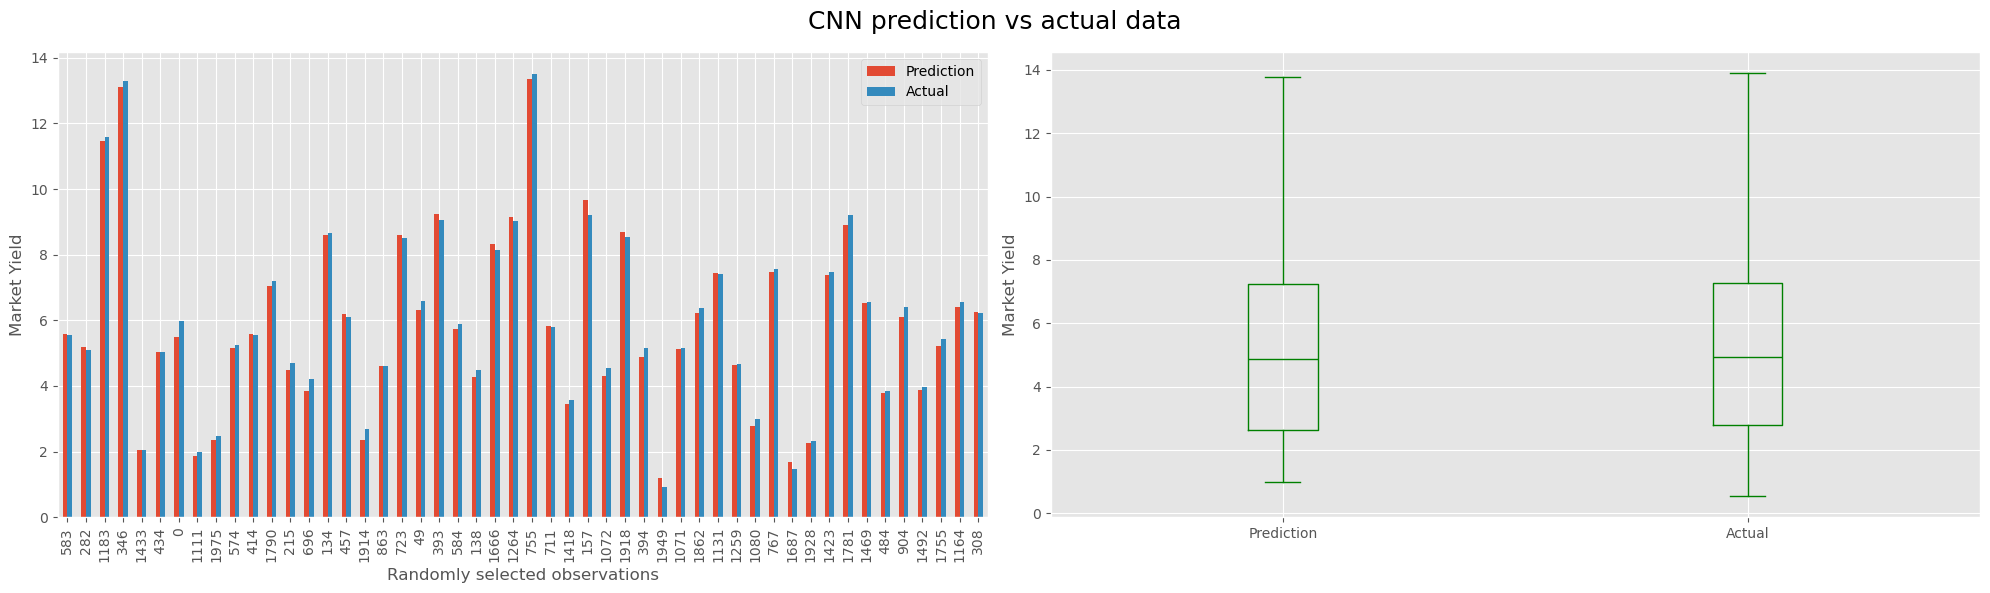

In [19]:
mpl.style.use(['ggplot'])

fig = plt.figure()
fig.suptitle('CNN prediction vs actual data', fontsize=18)

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df2[['Prediction','Actual']].sample(n=50, replace=False).plot(kind="bar", figsize=(20, 6), ax=ax0)
ax0.set_xlabel('Randomly selected observations')
ax0.set_ylabel('Market Yield')


df2[['Prediction','Actual']].plot(kind='box', color='green', figsize=(20, 6), ax=ax1)
ax1.set_ylabel('Market Yield')

plt.tight_layout()

<h3>Citations</h3>

-  Federal Reserve Bank of St. Louis, Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity [AAA10Y], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/AAA10Y, September 28, 2024
-  Organization for Economic Co-operation and Development, Financial Market: Share Prices for United States [SPASTT01USM661N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/SPASTT01USM661N, September 28, 2024
-  Federal Reserve Bank of Cleveland, 10-Year Expected Inflation [EXPINF10YR], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EXPINF10YR, September 28, 2024
-  Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [DFF], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DFF, September 28, 2024
-  Organization for Economic Co-operation and Development, Consumer Price Index: All Items: Total for United States [CPALTT01USM657N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPALTT01USM657N, September 28, 2024